# T-SNE Visualisation of Amazon Fine Food Reviews and its Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

#### Context:

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

#### Contents:

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review



## Datasets

The dataset is available in two forms
1. .csv file
2. SQLite Database

In this notebook, SQLITE dataset is used as it is easier to query the data and visualise the data efficiently.
<br> 



In [1]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import os
import pickle
from tqdm import tqdm

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



#  Loading Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('./Datasets/database.sqlite') 

#filtering out neutral rated reviews
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 


In [3]:

# Assigning a positive rating for reviews with Score>3 and a negative rating for reviews with a score<3
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive(1) and vice-versa(0)
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 

In [4]:
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


In [5]:
filtered_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,1,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,1,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
filtered_data.shape
#filtered_data['UserId']

(525814, 10)

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

# Checking the count of positive and negative reviews
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

Out of total 3,64,171 reviews 3,07,061 reviews are positive i.e., 84% are +ve and rest 57,110 reviews are negative

In [14]:
final.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,282794.124280,1.739153,2.187129,0.843178,1.296135e+09
std,164591.760568,6.724585,7.349707,0.363633,4.864772e+07
min,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,140715.500000,0.000000,0.000000,1.000000,1.270858e+09
50%,278980.000000,0.000000,1.000000,1.000000,1.311379e+09
75%,428539.500000,2.000000,2.000000,1.000000,1.332893e+09
max,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


# Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [17]:
# Using BeautifulSoup
# Beautiful Soup is a Python package for parsing HTML and XML documents.
# It creates a parse tree for parsed pages that can be used to extract data from XML, which is useful for web scraping.
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [22]:
# https://gist.github.com/sebleier/554280
# Following words are removed from the below stopwords list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above performed operations and to clean all reviews
# cleaned review texts are stored in preprocessed_reviews Array

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:08<00:00, 1933.13it/s]


In [25]:
preprocessed_reviews[5]

'charming rhyming book describes circumstances eat not chicken soup rice month month sounds like kind thing kids would make recess sing drive teachers crazy cute catchy sounds really childlike skillfully written'

In [26]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=preprocessed_reviews

In [27]:
final.shape

(364171, 11)

In [28]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


# Featurization

As TSNE deals with sparse matrices and plotting takes much memory and time, here only 6000 data points were considered

In [29]:
#Samples were taken randomly
data_pos = final[final["Score"] == 0].sample(n = 3000)
data_neg = final[final["Score"] == 1].sample(n = 3000)
final_6000 = pd.concat([data_pos, data_neg])

In [30]:
final_6000.shape

(6000, 11)

In [31]:
final_6000.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
383898,415136,B000U90MNG,A13M2GOUN7BEYZ,amplet,1,1,0,1319241600,Yuck,I would rather have a salad plain than have to...,would rather salad plain eat tried many low ca...
300278,325250,B0033GMSTY,A3EIY01UK5XIQF,anonymous,0,0,0,1308096000,not Donut Shop coffee,This is not the same as the 'Donut Shop' coffe...,not donut shop coffee comes keurig brewer not ...
119527,129614,B007EVYCES,A1ALPOZ0NRWR0A,Harold Edmondson,2,2,0,1347321600,poor packaging,Wish I could review the product but it was so ...,wish could review product poorly packaged not ...
504022,545017,B0047EK6ZY,A282ZRQYYO6S4Z,Michelle A. Wilson,1,1,0,1297987200,Not what was ordered,I ordered the pictured product (organic roaste...,ordered pictured product organic roasted cacao...
500556,541193,B00017LEZC,A3VB7HPB5MA1VZ,a reader in America,4,7,0,1223683200,Not so great,We had to throw it out. The corn pops up sogg...,throw corn pops soggy bit stale something bag ...


In [32]:
final.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
178145,193174,B009RSR8HO,A4P6AN2L435PV,romarc,0,0,1,1350432000,LOVE!! LOVE!!,"LOVE, LOVE this sweetener!! I use it in all m...",love love sweetener use baking unsweetened fla...
173675,188389,B009SF0TN6,A1L0GWGRK4BYPT,Bety Robinson,0,0,1,1350518400,Amazing!! Great sauce for everything!,You have to try this sauce to believe it! It s...,try sauce believe starts little sweet honey ta...
204727,221795,B009SR4OQ2,A32A6X5KCP7ARG,sicamar,1,1,1,1350604800,Awesome Taste,I bought this Hazelnut Paste (Nocciola Spread)...,bought hazelnut paste nocciola spread local sh...
5259,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...,purchased product local store ny kids love qui...
302474,327601,B009WVB40S,A3ME78KVX31T21,K'la,0,0,1,1351123200,Tasty!,I purchased this to send to my son who's away ...,purchased send son away college delivered righ...


In [33]:
preprocessed_reviews = final_6000['CleanedText']

In [34]:
preprocessed_reviews.shape

(6000,)

In [35]:
final_6000['CleanedText'].shape

(6000,)

In [36]:
preprocessed_reviews.head()

383898    would rather salad plain eat tried many low ca...
300278    not donut shop coffee comes keurig brewer not ...
119527    wish could review product poorly packaged not ...
504022    ordered pictured product organic roasted cacao...
500556    throw corn pops soggy bit stale something bag ...
Name: CleanedText, dtype: object

In [37]:
preprocessed_reviews.tail()

430790    addicted cheesey bunnies ages family four love...
248226    best plunger type powerfull type works great s...
347553    nice mellow tea occassions ex coffee drinker s...
3346      sweet juicy yummy try hard not eat much one ti...
63063     used purchase local grocery store whatever rea...
Name: CleanedText, dtype: object

## BAG OF WORDS

1. A bag-of-words is a representation of text that describes the occurrence of words within a document
2. In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity.
3. Count the number of times each word appears in a document and this results in a vector with lots of zero scores, called a sparse vector or sparse representation.
4. A problem with scoring word frequency is that highly frequent words start to dominate in the document (e.g. larger score), but may not contain as much “informational content” to the model as rarer but perhaps domain specific words.

In [38]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aagh', 'abandon', 'abc', 'abd', 'abdomen', 'abdominal', 'abhorrent', 'abiding']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 16417)
the number of unique words  16417


## Bi-Grams

In [52]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (6000, 3920)
the number of unique words including both unigrams and bigrams  3920


## TF-IDF(Term Frequency – Inverse Document Frequency)

<b>Term Frequency:</b> is a scoring of the frequency of the word in the current document.

<b> Inverse Document Frequency:</b> is a scoring of how rare the word is across documents.
    
  *  The tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. 
  * The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 
  *  Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.
  *  Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.
    
   <b>TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).</b>
   
   <b>IDF(t) = log_e(Total number of documents / Number of documents with term t in it).</b>
 
<b>Example: </b>
Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

References : Wikipedia and http://www.tfidf.com/

In [53]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely loves', 'absolutely no', 'absorb']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6000, 3920)
the number of unique words including both unigrams and bigrams  3920


In [54]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[3000:3010])

some sample features(unique words in the corpus) ['seaweed', 'second', 'second time', 'seconds', 'secret', 'section', 'see', 'see amazon', 'see could', 'seed']


In [55]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,10)

In [56]:
top_tfidf

,feature,tfidf
0,intense,0.307149
1,ok not,0.302174
2,not fresh,0.291724
3,definitely not,0.265638
4,strawberry,0.256285
5,remember,0.255449
6,years ago,0.251488
7,seemed,0.231616
8,cream,0.225704
9,stale,0.224444


## Word2Vec

*   Word2vec represents words in vector space representation. 
*    Words are represented in the form of vectors and placement is done in such a way that similar meaning words appear together and dissimilar words are located far away. This is also termed as a semantic relationship. 
*     Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space
*    Neural networks do not understand text instead they understand only numbers. Word Embedding provides a way to convert text to a numeric vector
*    Word embedding is a way to perform mapping using a neural network.
*    These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words

In [57]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [58]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    

[('better', 0.9792722463607788), ('much', 0.9784468412399292), ('pretty', 0.9750475883483887), ('think', 0.9745003581047058), ('either', 0.9702962040901184), ('regular', 0.9695765972137451), ('remotely', 0.967951238155365), ('though', 0.9670844674110413), ('nothing', 0.9651418328285217), ('coffe', 0.96454918384552)]
[('hazelnut', 0.9986299276351929), ('mocha', 0.998345136642456), ('bitterness', 0.9983235597610474), ('fan', 0.9982897043228149), ('mountain', 0.9982307553291321), ('robust', 0.9981549382209778), ('blend', 0.9980712532997131), ('roasted', 0.9980252981185913), ('far', 0.9979569315910339), ('mate', 0.997775673866272)]


In [59]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4709
sample words  ['something', 'wrong', 'product', 'excellent', 'buying', 'several', 'years', 'first', 'whole', 'foods', 'dropped', 'purchasing', 'online', 'fact', 'purchased', 'original', 'larger', 'size', 'jar', 'decreased', 'oz', 'selling', 'price', 'remained', 'also', 'flavors', 'really', 'delicious', 'going', 'considerably', 'purchase', 'jars', 'per', 'order', 'save', 'shipping', 'always', 'another', 'increase', 'recent', 'september', 'apparently', 'packed', 'warehouse', 'sent', 'store', 'not', 'box', 'six', 'sealed']


In [60]:
w2v_model.wv.most_similar('nice')

[('rich', 0.997947096824646),
 ('smooth', 0.9975689053535461),
 ('aftertaste', 0.9973089694976807),
 ('delicious', 0.9972301125526428),
 ('light', 0.9969566464424133),
 ('fruity', 0.996487021446228),
 ('honey', 0.9962704181671143),
 ('aroma', 0.9951620697975159),
 ('smoother', 0.9947112202644348),
 ('watered', 0.994592010974884)]

## Converting text into vectors using wAvg W2V, TFIDF-W2V

#### Avg W2v

In [61]:
# average Word2Vec
# computes average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 6000/6000 [00:09<00:00, 633.33it/s]

6000
50


In [62]:
avg_vec = np.array(sent_vectors)
avg_vec.shape

(6000, 50)

#### TFIDF weighted W2v

In [63]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [64]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
            # to reduce the computation we are 
            # dictionary[word]: idf value of word in whole Corpus
            # sent.count(word): tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 6000/6000 [00:52<00:00, 127.19it/s]


# t-SNE (t-distributed Stochastic Neighbour Embedding)
*    t-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton.[1] 
*    It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. 
*    Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
*    t-SNE is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data.
*    It maps multi-dimensional data to two or more dimensions suitable for human observation. 
*    With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

# Applying t-SNE on word embedding

## Applying TNSE on Text BOW vectors

In [39]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_counts)
std_data.shape

(6000, 16417)

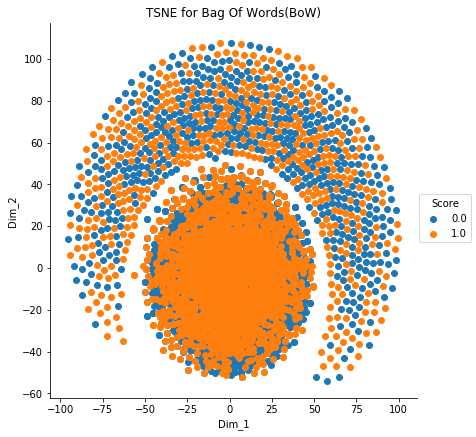

In [40]:
from sklearn.manifold import TSNE
import seaborn as sn

model = TSNE(n_components=2, random_state=0)

std_data = std_data.todense()
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, final_6000["Score"])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Score"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE for Bag Of Words(BoW)")
plt.show()


<b>Observations:</b> Positive and negative reviews are completely overlapped. Its not possible to seperate both from BoW

## Applying TNSE on Text TFIDF vectors

In [70]:
final_tf_idf.shape

(6000, 3920)

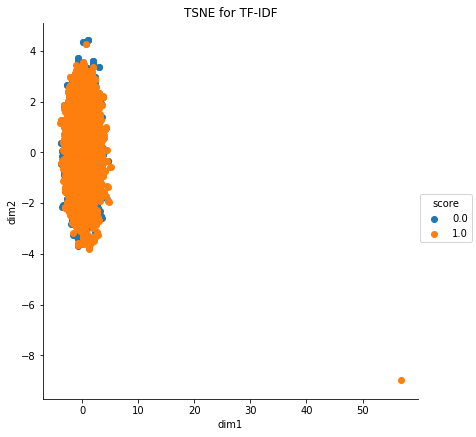

In [71]:
std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
std_data.shape
std_data = std_data.todense()
#std_data.shape

tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, final_6000["Score"])).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

<b>Observations:</b> Positive and negative reviews are completely overlapped. Its not possible to seperate both from Tf-Idf

## Applying TSNE on Text Avg W2V vectors

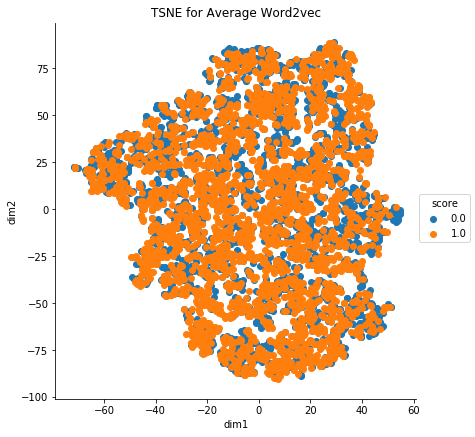

In [72]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, final_6000["Score"])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()


<b>Observations:</b> Positive and negative reviews are completely overlapped. Its not possible to seperate both from Averaged Word2Vec

## Applying TNSE on Text TFIDF weighted W2V vectors

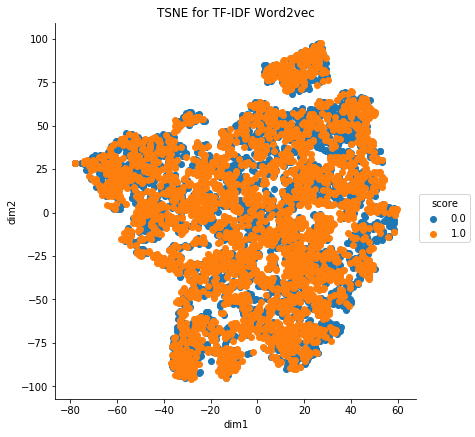

In [74]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, final_6000["Score"])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

<b>Observations:</b> Positive and negative reviews are completely overlapped. Its not possible to seperate both from Tf-Idf Word2Vec

# Conclusions

## observations:
*    Duplicate reviews are observed
*    84% reviews are Positive
*    Word embeddings are causing sparsity
*    For all the plots like BOW, TfIdf, word2vec, avg-word2vec and Tfidf-word2vec, both positive and negative reviews are overlapped each other.
*    Here from T-SNE we cannot draw seperate boundaries for both the class labels.

